# Deep Q Network
1. Deep neural network
2. Experience replay

## Algorithm - DQN

![Algorithm](https://cdn-images-1.medium.com/max/800/1*5ffOxpSgIJCYn0XccfFYUQ.png)

**Problem**
* **Catastrophic interference**
  * Q tables suffer from the curse of dimensionality. The space complexity of Q tables grows exponentially with the number of states * actions.
  * Using a deep neural network to predict Q values of each state/action resolves this issue. However, deep NNs suffer from catastrophic interference, or 'catastrophic forgetting', to completely and abruptly forget previously learned information upon learning new information, because neural networks are sensitive, but not disrupted by, new information.
  * Lookup tables, on the other hand, remains completely stable in the presence of new information but lacks the ability to generalize, i.e. infer general principles, from new inputs.
* **Highly correlated experiences**
  * Because every action affects the next state, there is also a risk of influencing our agent with highly correlated experiences. Doing many iterations of gradient descent on similar and correlated inputs may lead to overfit them and/or fall into a local minimum. 
  
**Solution**
* Therefore, we use **experience replay** to train the Q network. Experience replay stores experiences in a replay buffer to be sampled to train the Q network.
* Experience replay resolves **catastrophic interference** because experiences from long ago can be sampled from the replay buffer to retrain the Q network.
* Experience replay also resolves **highly correlated experiences** because we sample from a normal distribution of experiences instead of a sequential order to break up the correlation between experiences.

## References
* Deep Q Learning
    * https://github.com/keon/deep-q-learning/blob/master/dqn.py
* Deep Q  Networks
    * https://www.novatec-gmbh.de/en/blog/deep-q-networks/
* RL - DQN Deep Q-network
    * https://medium.com/@jonathan_hui/rl-dqn-deep-q-network-e207751f7ae4
* What is "experience replay" and what are its benefits?
    * https://datascience.stackexchange.com/questions/20535/what-is-experience-replay-and-what-are-its-benefits
* Catastrophic Interference
    * https://en.wikipedia.org/wiki/Catastrophic_interference
* Why is deep reinforcement learning unstable?
    * https://stats.stackexchange.com/questions/265964/why-is-deep-reinforcement-learning-unstable

In [0]:
#@title Import EpisodeStats, plot_episode_stats
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [2]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import itertools

EPISODES = 500

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0
        self.epsilon_decay = 0.9995
        self.learning_rate = 0.001
        self.model = self.build_model()

    def build_model(self):
        """Deep Q Network"""
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        """Save transition into memory."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Predict action based on greedy-epsilon."""
        # Explore
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        # Exploit
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        """Experience replay through random sampling. Decay epsilon."""
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """Load model."""
        self.model.load_weights(name)

    def save(self, name):
        """Save model."""
        self.model.save_weights(name)

Using TensorFlow backend.


In [3]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 500
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
# agent.load("./save/cartpole-dqn.h5")
done = False
batch_size = 32

# For graphing
stats = EpisodeStats(
    episode_lengths=np.zeros(EPISODES),
    episode_rewards=np.zeros(EPISODES))

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    for time in range(500):
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}, time: {}"
                  .format(e, EPISODES, total_reward, agent.epsilon, time))
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        # For graphing
        stats.episode_rewards[e] += reward
        stats.episode_lengths[e] = time
    # if e % 10 == 0:
    #     agent.save("./save/cartpole-dqn.h5")

Instructions for updating:
Colocations handled automatically by placer.
episode: 0/500, score: -3.0, e: 1.0, time: 7
Instructions for updating:
Use tf.cast instead.
episode: 1/500, score: 30.0, e: 0.99, time: 40
episode: 2/500, score: 10.0, e: 0.98, time: 20
episode: 3/500, score: 2.0, e: 0.98, time: 12
episode: 4/500, score: -1.0, e: 0.97, time: 9
episode: 5/500, score: 13.0, e: 0.96, time: 23
episode: 6/500, score: 3.0, e: 0.95, time: 13
episode: 7/500, score: 13.0, e: 0.94, time: 23
episode: 8/500, score: 21.0, e: 0.93, time: 31
episode: 9/500, score: 4.0, e: 0.92, time: 14
episode: 10/500, score: 3.0, e: 0.92, time: 13
episode: 11/500, score: 10.0, e: 0.91, time: 20
episode: 12/500, score: -1.0, e: 0.9, time: 9
episode: 13/500, score: 5.0, e: 0.9, time: 15
episode: 14/500, score: 1.0, e: 0.89, time: 11
episode: 15/500, score: 11.0, e: 0.88, time: 21
episode: 16/500, score: 2.0, e: 0.88, time: 12
episode: 17/500, score: 3.0, e: 0.87, time: 13
episode: 18/500, score: 5.0, e: 0.86, ti

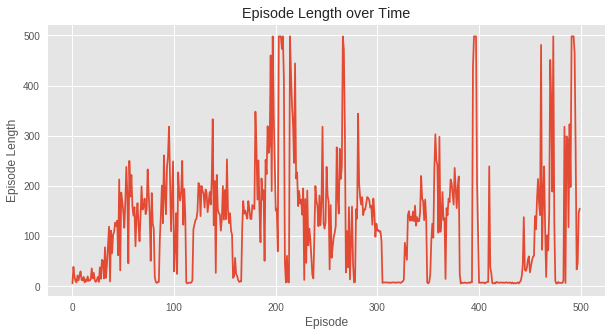

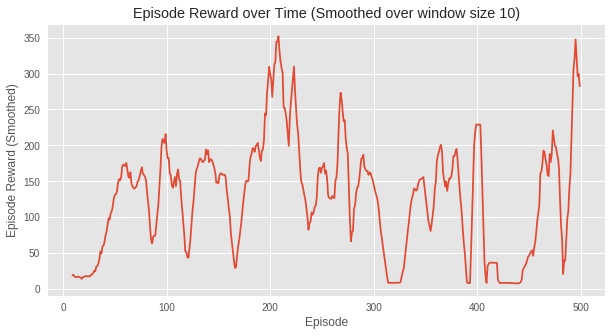

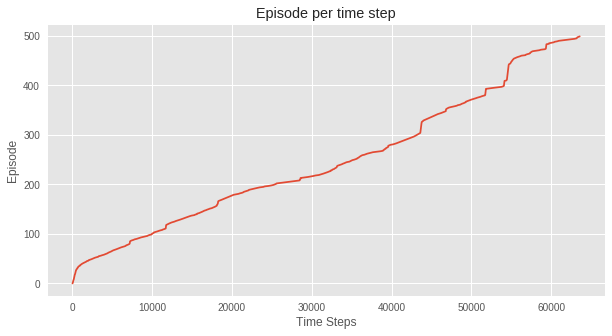

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [4]:
plot_episode_stats(stats)